In [37]:
import pandas as pd

drug_df = pd.read_csv("Data/drug.csv")
drug_df = drug_df.sample(frac=1)
drug_df.head(3)

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
99,15,F,HIGH,NORMAL,16.725,DrugY
175,73,F,HIGH,HIGH,18.348,DrugY
92,29,F,HIGH,HIGH,29.450,DrugY


In [38]:
from sklearn.model_selection import train_test_split

X = drug_df.drop("Drug", axis=1).values
y = drug_df.Drug.values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=125
)

In [39]:
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, StandardScaler

cat_col = [1,2,3]
num_col = [0,4]

transform = ColumnTransformer(
    [
        ("encoder", OrdinalEncoder(), cat_col),
        ("num_imputer", SimpleImputer(strategy="median"), num_col),
        ("num_scaler", StandardScaler(), num_col),
    ]
)
pipe = Pipeline(
    steps=[
        ("preprocessing", transform),
        ("model", RandomForestClassifier(n_estimators=10, random_state=125)),
    ]
)
pipe.fit(X_train, y_train)

,steps,"[('preprocessing', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('encoder', ...), ('num_imputer', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [40]:
from sklearn.metrics import accuracy_score, f1_score

predictions = pipe.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
f1 = f1_score(y_test, predictions, average="macro")

print("Accuracy: ", str(round(accuracy, 2) * 100) + "%", "F1: ", round(f1, 2))

Accuracy:  92.0% F1:  0.84


In [41]:
# Write metrics to file
with open("Results/metrics.txt", "w") as outfile:
    outfile.write(f"\nAccuracy = {round(accuracy,2)}, F1 Score = {round(f1,2)}.")

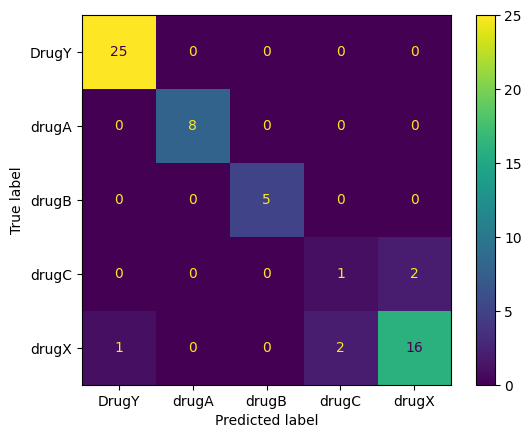

In [42]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

predictions = pipe.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=pipe.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe.classes_)
disp.plot()
plt.savefig("Results/model_results.png", dpi=120)

In [43]:
import skops.io as sio

sio.dump(pipe, "Model/drug_pipeline.skops")

In [44]:
from skops.io import get_untrusted_types, load

# Step 1: Retrieve a list of types not trusted by default
untrusted = get_untrusted_types(file="Model/drug_pipeline.skops")
print("Untrusted types:", untrusted)

# Step 2: After reviewing, load the model by trusting the approved types
pipeline = load("Model/drug_pipeline.skops", trusted=untrusted)


Untrusted types: ['numpy.dtype']
